In [ ]:
## 用chatgopenai-ollama替换langgraph对应云模型出错，应该是模型输出形式不匹配

In [11]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
import os
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"]="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"
os.environ["LANGCHAIN_PROJECT"]="pr-sunny-icicle-8"
os.environ["TAVILY_API_KEY"] = "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"

class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="qwen2:7b",base_url = 'http://localhost:11434/v1',api_key='ollama')
llm_with_tools = llm.bind_tools(tools)
#response = llm.invoke("hello")
#print(response)

def chatbot(state: State):
    print(state["messages"])
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [12]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")
graph = graph_builder.compile(checkpointer=memory)

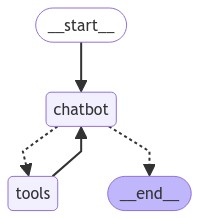

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
config = {"configurable": {"thread_id": "1"}}
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
[HumanMessage(content='Hi there! My name is Will.', id='cd533b87-e67c-44e5-9514-1f2c7cfef3b3')]


BadRequestError: Error code: 400 - {'error': {'message': 'qwen2:7b does not support tools', 'type': 'api_error', 'param': None, 'code': None}}